In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix

In [83]:
dir_path='prepared_dataset'

#training dataset
x_train=np.load(os.path.join(dir_path,'train_images.npy'))
y_train=np.load(os.path.join(dir_path,'train_labels.npy'))

#cross validation dataset
x_cv=np.load(os.path.join(dir_path,'cross_validation_images.npy'))
y_cv=np.load(os.path.join(dir_path,'cross_validation_labels.npy'))

#test dataset
x_test=np.load(os.path.join(dir_path,'test_images.npy'))
y_test=np.load(os.path.join(dir_path,'test_labels.npy'))

In [84]:
y_train=np.expand_dims(y_train,axis=1)
y_cv=np.expand_dims(y_cv,axis=1)
y_test=np.expand_dims(y_test,axis=1)

In [85]:
print(f"shape of X_train,y_train = {x_train.shape},{y_train.shape} \n"+
      f"shape of X_cv,y_cv = {x_cv.shape},{y_cv.shape} \n"+
      f"shape of X_test,y_test = {x_test.shape},{y_test.shape}")

shape of X_train,y_train = (445, 278, 278, 3),(445, 1) 
shape of X_cv,y_cv = (56, 278, 278, 3),(56, 1) 
shape of X_test,y_test = (56, 278, 278, 3),(56, 1)


In [86]:
features=278*278*3

x_train_reshaped=x_train.reshape((445,features))
x_cv_reshaped=x_cv.reshape((56,features))
x_test_reshaped=x_test.reshape((56,features))

print("After reshaping : ")
print(f"shape of X_train,y_train = {x_train_reshaped.shape},{y_train.shape} \n"+
      f"shape of X_cv,y_cv = {x_cv_reshaped.shape},{y_cv.shape} \n"+
      f"shape of X_test,y_test = {x_test_reshaped.shape},{y_test.shape}")

After reshaping : 
shape of X_train,y_train = (445, 231852),(445, 1) 
shape of X_cv,y_cv = (56, 231852),(56, 1) 
shape of X_test,y_test = (56, 231852),(56, 1)


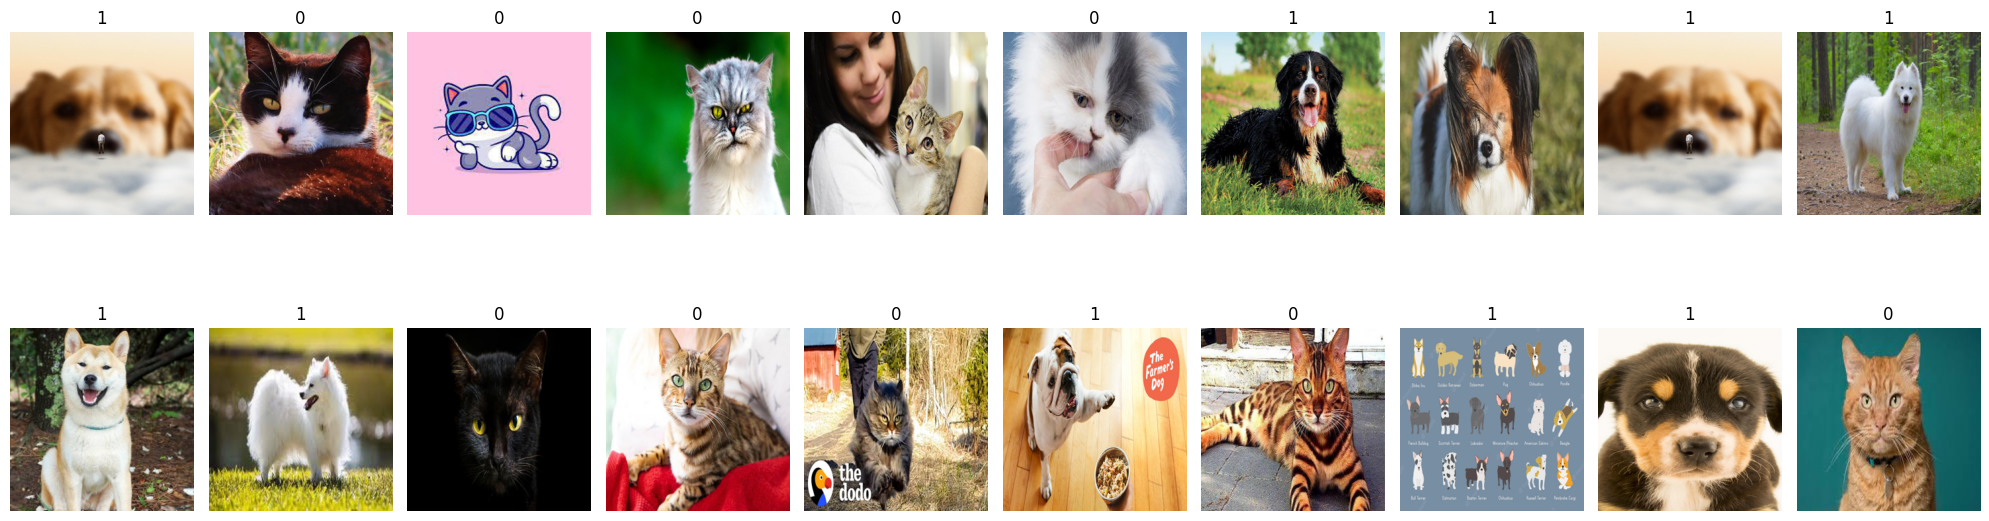

In [87]:
fig,axis=plt.subplots(2,10,figsize=(20,10))
np.random.seed(42)
for i in range(2):
    for j in range(10):
        index=np.random.randint(x_train.shape[0])
        axis[i,j].imshow(x_train[index].reshape(278,278,3))
        axis[i,j].set_title(y_train[index].squeeze())
        axis[i,j].set_axis_off()
        plt.tight_layout()
        


In [88]:
model = Sequential([
        tf.keras.Input((231852,)),
        Dense(units=278, activation='relu', name='layer_1',kernel_regularizer=l2(0.1)),
        Dense(units=128, activation='relu', name='layer_2',kernel_regularizer=l2(0.1)),
        Dense(units=128, activation='relu', name='layer_3',kernel_regularizer=l2(0.1)),
        Dense(units=1, activation='linear', name='layer_4',kernel_regularizer=l2(0.1))
    ], name='model')

model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_1 (Dense)                 │ (None, 278)            │    64,455,134 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 128)            │        35,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,507,487 (246.08 MB)

 Trainable params: 64,507,487 (246.08 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
model.compile(optimizer=Adam(0.0005),loss=BinaryCrossentropy(from_logits=True))

history=model.fit(x_train_reshaped,y_train,epochs=100)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 874ms/step - loss: 181.1066
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 900ms/step - loss: 100.4337
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 895ms/step - loss: 58.8170
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 897ms/step - loss: 35.8664
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 895ms/step - loss: 23.7296
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 901ms/step - loss: 21.1463
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 909ms/step - loss: 18.8571
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 896ms/step - loss: 16.5358
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 900ms/step - loss: 12.8960
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 903ms/step - loss: 8.9687
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 913ms/step - loss: 6.4526
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 894ms/step - loss: 4.9213
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 898ms/step - loss: 3.9571
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 894ms/step - loss: 3.3162
Epoch 15/100
14/14

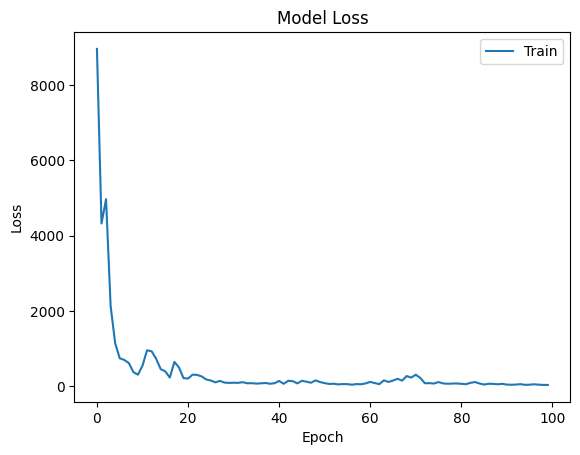

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
threshold=0.5

#J_train
logits_train=model.predict(x_train_reshaped)
yhat_train=tf.nn.sigmoid(logits_train)
yhat_train=np.where(yhat_train>=threshold,1,0)
J_train=np.mean(yhat_train != y_train)

#J_cv
logits_cv=model.predict(x_cv_reshaped)
yhat_cv=tf.nn.sigmoid(logits_cv)
yhat_cv=np.where(yhat_cv>=threshold,1,0)
J_cv=np.mean(yhat_cv != y_cv)

print(f"J_train : {J_train} \n"+f"J_cv : {J_cv}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
J_train : 0.16179775280898875 
J_cv : 0.44642857142857145


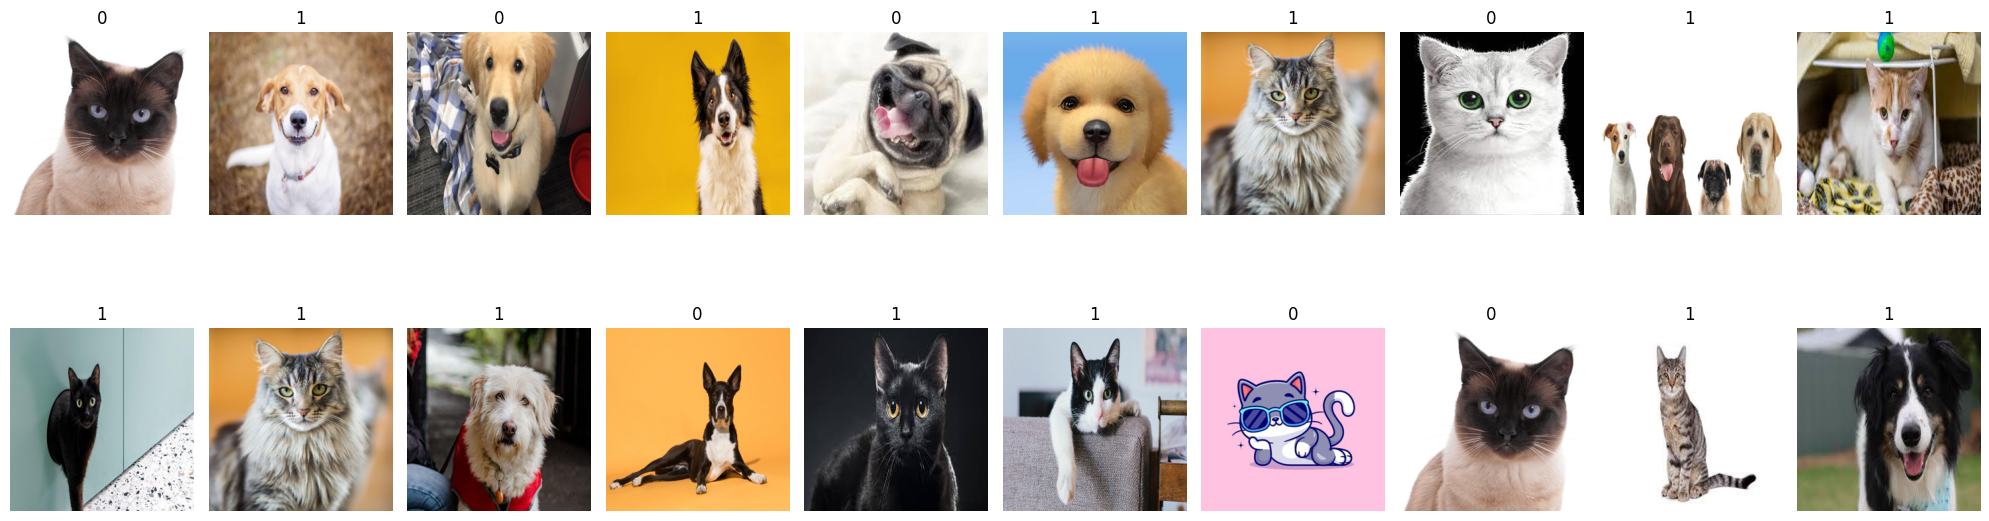

In [94]:
fig,axis=plt.subplots(2,10,figsize=(20,10))
for i in range(2):
    for j in range(10):
        index=np.random.randint(x_cv.shape[0])
        axis[i,j].imshow(x_cv[index].reshape(278,278,3))
        axis[i,j].set_title(yhat_cv[index].squeeze())
        axis[i,j].set_axis_off()
        plt.tight_layout()

In [3]:
confusion_matrix(y_cv,yhat_cv)

NameError: name 'y_cv' is not defined